# NN3: Implementacja momentu i normalizacji gradientu
## Laura Hoang, 313366

Zaimplementować dwa usprawnienia uczenia gradientowego sieci neuronowej:
- moment,
- normalizację gradientu RMSProp.

Porównać szybkość zbieżności procesu uczenia dla obu wariantów.

Przeprowadzić eksperymenty na zbiorach(w nawiasach wartość MSE, aby otrzymać 2 punkty):
- square-large (MSE: 1),
- steps-large (MSE: 3),
- multimodal-large (MSE: 9).

Literatura:
- Uczenie gradientowe z momentem: rozdział 3.2.2 Computational Intelligence, A. P. Engelbrecht
- Normalizacja gradientu: Wykład 6e: http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf

## Importowanie bibliotek

In [1]:
import pandas as pd
import numpy as np
from numpy import dot, square, subtract
from scipy.special import expit

from matplotlib import pyplot as plt

np.random.seed(420)

## Implementacja sieci (NN2 + usprawnienia uczenia gradientowego)

In [2]:
# funkcja aktywacji
def sigmoid(x):
    return expit(x)  # wersja stabilna numerycznie


# pochodna funkcji aktywacji
def sigmoid_der(x):
    return sigmoid(x) * (1 - sigmoid(x))


# błąd średniowkadratowy
def mse(y, y_hat):
    return square(subtract(y, y_hat)).mean()

In [3]:
class NeuralNetwork():
    def __init__(self, number_of_neurons=[], activation=sigmoid, activation_der=sigmoid_der, initiate_w_b="Uniform"):
        # activation - funkcja aktywacji: sigmoid(default)
        # activation_der - pochodna funkcji aktywacji: sigmoid_der(default)
        # initiate_w_b - ustalanie metody inicjowania począkowych wag (i biasów): Uniform(default) / Xavier

        self.number_of_neurons = number_of_neurons  # liczba neuronów w każdej warstwie (wliczając wejście i wyjście)
        self.synaptic_weights = []                  # lista z wagami
        self.biases = []                            # lista biasów

        self.activation = activation
        self.activation_der = activation_der

        self.delta_w_mean = []   # średnia ze zmian wag w propagacji wstecznej
        self.delta_b_mean = []   # średnia ze zmian biasow w propagacji wstecznej

        if initiate_w_b == "Xavier":
            self.weights_xavier(number_of_neurons)
        else:
            self.weights_uniform(number_of_neurons)


    def weights_uniform(self, number_of_neurons):
        for i in range(len(self.number_of_neurons) - 1):
            self.synaptic_weights += [np.random.uniform(-1, 1, self.number_of_neurons[i] * self.number_of_neurons[i + 1]).reshape(number_of_neurons[i], self.number_of_neurons[i + 1])]
            self.biases += [np.random.uniform(-1, 1, self.number_of_neurons[i + 1]).reshape(1, self.number_of_neurons[i+1])]


    def weights_xavier(self, number_of_neurons):
        xavier = np.sqrt(6)/np.sqrt(self.number_of_neurons[1]+self.number_of_neurons[-1])
        for i in range(len(self.number_of_neurons) - 1):
            self.synaptic_weights += [xavier * np.random.uniform(-1, 1, self.number_of_neurons[i] * self.number_of_neurons[i + 1]).reshape(number_of_neurons[i], self.number_of_neurons[i + 1])]
            self.biases += [xavier * np.random.uniform(-1, 1, self.number_of_neurons[i + 1]).reshape(1, self.number_of_neurons[i+1])]


    def forward(self, input):
        self.A = []
        self.z = []

        self.A += [input]
        a = input

        number_of_hidden_layers = len(self.number_of_neurons)-2
        for layer in range(number_of_hidden_layers):
            output = dot(a, self.synaptic_weights[layer]) + self.biases[layer]
            self.z += [output]
            a = self.activation(output)
            self.A += [a]

        result = dot(a,self.synaptic_weights[-1]) + self.biases[-1]

        self.z += [result]
        self.A += [result]

        return result


    def backward(self, y):
        m = y.shape[0]
        D = [None] * len(self.synaptic_weights)
        D[-1] = y - self.A[-1]

        for i in reversed(range(len(D) - 1)):
            D[i] = (dot(self.synaptic_weights[i + 1], D[i + 1].T) * self.activation_der(self.z[i]).T).T

        delta_w = [None] * len(D)
        delta_b = [None] * len(D)

        for i, d in enumerate(D):
            delta_w[i] = dot(d.T, self.A[i]).T / m
            delta_b[i] = dot(d.T, np.ones((m, 1))).T / m

        return (delta_w, delta_b)


    def learn(self, x, y, batch_size=20, iterations=500, alpha=0.01, method = "Classic", var=0.4):
        ## Batchowe uczenie modelu, dla batch_size=1 mamy cały zbiór.
        # alpha - learning rate
        # method - wybór metody uczenia: Classic(default) / Momentum / RMSProp
        # var - współczynnik wygaszania
        
        np.random.seed(420)
        p = np.random.permutation(len(x))
        x = x[p]
        y = y[p]

        method_w = [np.zeros(w.shape) for w in self.synaptic_weights]
        method_b = [np.zeros(b.shape) for b in self.biases]

        for iteration in range(iterations):
            i = 0
            while i < len(y):
                x_batch = x[i : i+batch_size]
                y_batch = y[i : i+batch_size]

                i += batch_size
                self.forward(x_batch)
                (delta_w, delta_b) = self.backward(y_batch)

                self.delta_w_mean += [[np.mean(x) for x in delta_w]]
                self.delta_b_mean += [[np.mean(x) for x in delta_b]]

                if method == "Classic":
                    for j, weight in enumerate(self.synaptic_weights):
                        self.synaptic_weights[j] = weight + alpha * delta_w[j]
                    
                    for j, bias in enumerate(self.biases):
                        self.biases[j] = bias + alpha * delta_b[j]
                
                elif method == "Momentum":
                    for j, weight in enumerate(self.synaptic_weights):    
                        method_w[j] = method_w[j] * var + delta_w[j]
                        self.synaptic_weights[j] = weight + alpha * method_w[j]
                    
                    for j, bias in enumerate(self.biases):
                        method_b[j] = method_b[j] * var + delta_b[j]
                        self.biases[j] = bias + alpha * method_b[j]
                        
                elif method == "RMSProp":
                    for j, weight in enumerate(self.synaptic_weights):
                        method_w[j] = var * method_w[j] + (1-var) * delta_w[j] ** 2
                        self.synaptic_weights[j] = weight + alpha * (delta_w[j]/np.sqrt(method_w[j]) + 10**-8)
                    
                    for j, bias in enumerate(self.biases):
                        method_b[j] = var * method_b[j] + (1-var) * delta_b[j] ** 2
                        self.biases[j] = bias + alpha * (delta_b[j]/np.sqrt(method_b[j]) + 10**-8)



## Wizualizacje

In [4]:
def plot_train_test(x, y, x_test, y_test):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Zbiór treningowy vs. testowy')
    fig.set_size_inches(12,5)
    ax1.plot(x, y, 'o', markersize=3)
    ax2.plot(x_test, y_test, 'o', markersize=3)

def plot_mse(iterations_set, results_classic, results_momentum, results_rmsprop):
    df=pd.DataFrame({'x_values': iterations_set, 'Classic': results_classic, 'Momentum': results_momentum, 'RMSProp': results_rmsprop})
    plt.figure(figsize=(10,5))
    plt.title('Wartość MSE dla kolejnych liczb iteracji')
    plt.plot( 'x_values', 'Classic', data=df, marker='o', markerfacecolor='skyblue', markersize=3, color='skyblue', linewidth=2, linestyle='dotted')
    plt.plot( 'x_values', 'Momentum', data=df, marker='o', markerfacecolor='pink', markersize=3, color='pink', linewidth=2, linestyle='dotted')
    plt.plot( 'x_values', 'RMSProp', data=df, marker='o', markerfacecolor='grey', markersize=3, color='grey', linewidth=2, linestyle='dotted')
    plt.legend()

def plot_compare_3_pred(x,y,y1,y2,y3):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.suptitle('Porównanie dopasowania modeli dla metody klasycznej, Momentum i RMS')
    fig.set_size_inches(20,5)
    ax1.set_title('Klasyczna')
    ax1.scatter(x, y, s=10)
    ax1.scatter(x, y1, s=6)
    ax2.set_title('Momentum')
    ax2.scatter(x, y, s=10)
    ax2.scatter(x, y2, s=6)
    ax3.set_title('RMS')
    ax3.scatter(x, y, s=10)
    ax3.scatter(x, y3, s=6)
    print('MSE:', mse(y, y1), mse(y, y2), mse(y, y3))


In [5]:
# iterations_set = [5, 10, 20, 75, 100, 150, 200, 500, 1000]
# iterations_set = [20, 100, 150, 200]
iterations_set = [50, 100, 200, 500, 1000]

## Pierwszy zbiór danych (*square large*)

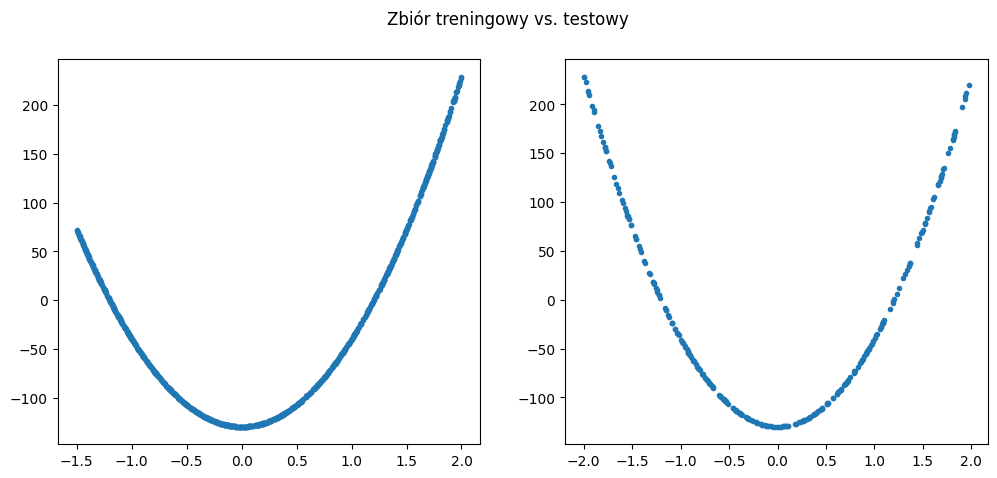

In [6]:
train_df = pd.read_csv('square-large-training.csv', index_col=0)
test_df = pd.read_csv('square-large-test.csv', index_col=0)

x = np.asarray(train_df['x']).reshape(-1, 1)
y = np.asarray(train_df['y']).reshape(-1, 1)
x_test = np.asarray(test_df['x']).reshape(-1,1)
y_test = np.asarray(test_df['y']).reshape(-1, 1)

plot_train_test(x,y,x_test,y_test)

In [7]:
number_of_neurons=[1, 500, 1]

results_classic = []
results_momentum = []
results_rmsprop = []

min_mse_classic = np.inf
min_mse_momentum = np.inf
min_mse_rmsprop = np.inf

nn_classic_best = None
nn_momentum_best = None
nn_rmsprop_best = None

for iterations in iterations_set:
    nn_classic = NeuralNetwork(number_of_neurons = number_of_neurons, activation = sigmoid, activation_der = sigmoid_der, initiate_w_b = "Uniform")
    nn_classic.learn(x, y, iterations=iterations, batch_size = 20, alpha=0.02, method = "Classic")
    y_pred_classic = nn_classic.forward(x_test)  # predykcja
    results_classic.append(mse(y_test, y_pred_classic))  # dodajemy MSE z predyckji vs real vals
    if min_mse_classic > mse(y_test, y_pred_classic):   # gdy natrafimy na nowy dobry model, podmieniamy
        nn_classic_best = nn_classic
        min_mse_classic = mse(y_test, y_pred_classic)

    nn_momentum = NeuralNetwork(number_of_neurons = number_of_neurons, activation = sigmoid, activation_der = sigmoid_der, initiate_w_b = "Uniform")
    nn_momentum.learn(x, y, iterations=iterations, batch_size = 20, alpha=0.02, var=0.9, method = "Momentum")
    y_pred_momentum = nn_momentum.forward(x_test)
    results_momentum.append(mse(y_test, y_pred_momentum))
    if min_mse_momentum > mse(y_test, y_pred_momentum):
        nn_momentum_best = nn_momentum
        min_mse_momentum = mse(y_test, y_pred_momentum)

    nn_rmsprop = NeuralNetwork(number_of_neurons = number_of_neurons, activation = sigmoid, activation_der = sigmoid_der, initiate_w_b = "Uniform")
    nn_rmsprop.learn(x, y, iterations=iterations, batch_size = 20, alpha=0.01, var=0.75, method = "RMSProp")
    y_pred_rmsprop = nn_rmsprop.forward(x_test)
    results_rmsprop.append(mse(y_test, y_pred_rmsprop))
    if min_mse_rmsprop > mse(y_test, y_pred_rmsprop):
        nn_rmsprop_best = nn_rmsprop
        min_mse_rmsprop = mse(y_test, y_pred_rmsprop)

y_pred_classic = nn_classic_best.forward(x_test)
y_pred_momentum = nn_momentum_best.forward(x_test)
y_pred_rmsprop = nn_rmsprop_best.forward(x_test)


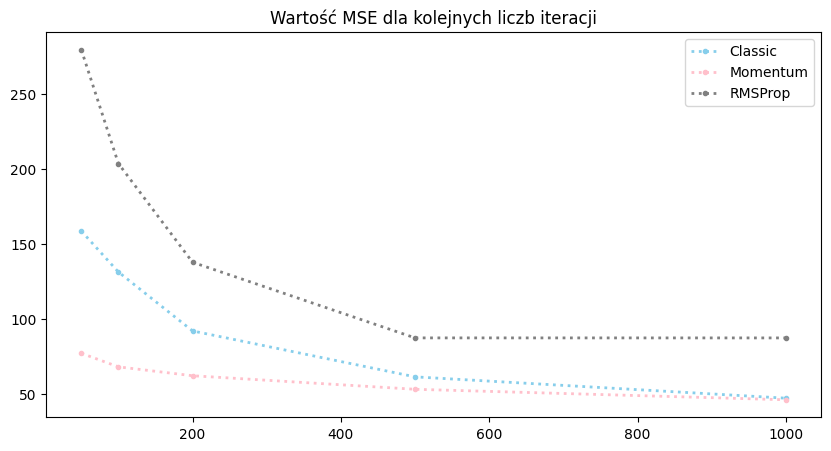

In [8]:
plot_mse(iterations_set, results_classic, results_momentum, results_rmsprop)

MSE: 47.05831960048143 45.99729567921775 87.24616751529868


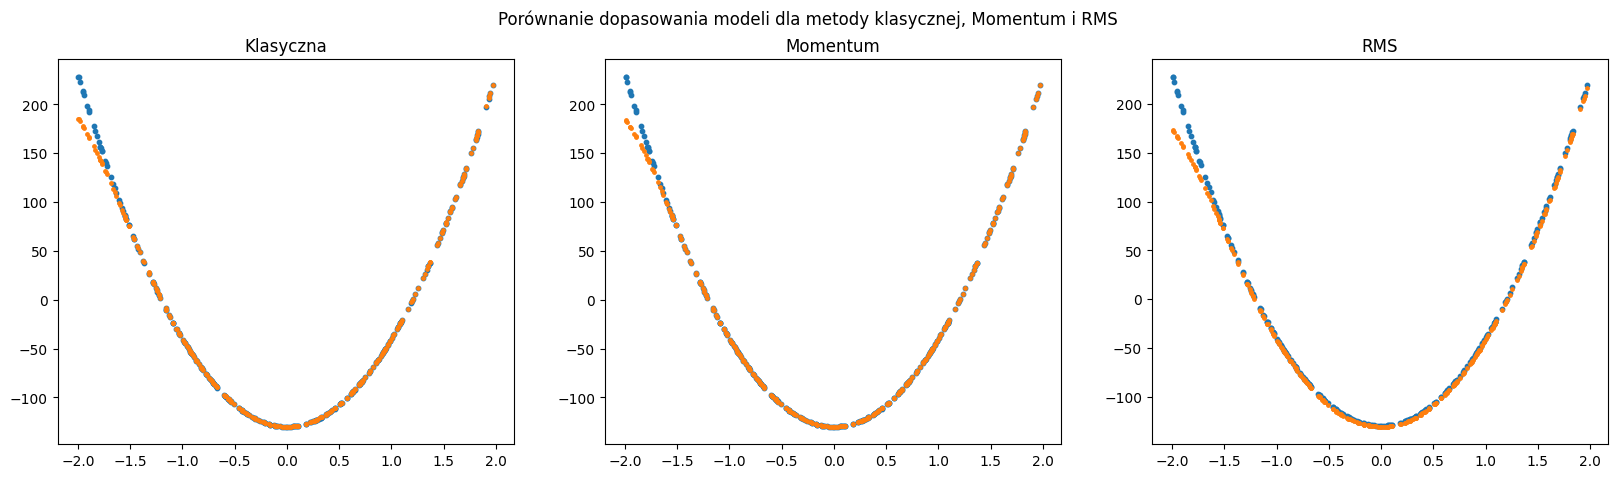

In [9]:
plot_compare_3_pred(x_test, y_test, y_pred_classic, y_pred_momentum, y_pred_rmsprop)

### Ucięte dane testowe
Wyniki dla oryginalnych danych testowych były wysokie, ponieważ zawierają x należące do przedziału, którego nie było w zbiorze treningowym. Z tego powodu zbadane zostaną również dane testowe "ucięte" (dla `x>-1.5`).

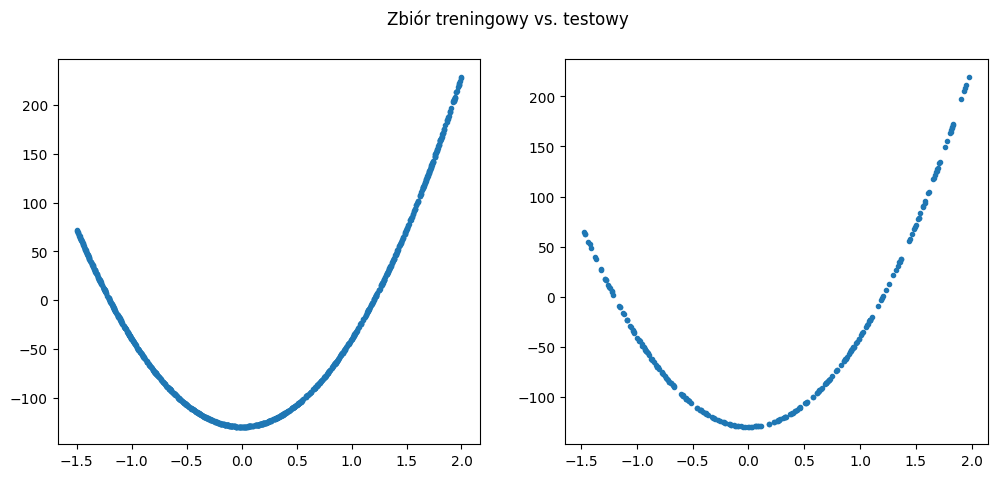

In [10]:
train_df = pd.read_csv('square-large-training.csv', index_col=0)
test_df = pd.read_csv('square-large-test.csv', index_col=0)

x = np.asarray(train_df['x']).reshape(-1, 1)
y = np.asarray(train_df['y']).reshape(-1, 1)

min_x = min(x)[0]

test_df = test_df[test_df['x'] > min_x]
x_test = np.asarray(test_df['x']).reshape(-1,1)
y_test = np.asarray(test_df['y']).reshape(-1, 1)

plot_train_test(x,y,x_test,y_test)

In [11]:
number_of_neurons=[1, 500, 1]

results_classic = []
results_momentum = []
results_rmsprop = []

min_mse_classic = np.inf
min_mse_momentum = np.inf
min_mse_rmsprop = np.inf

nn_classic_best = None
nn_momentum_best = None
nn_rmsprop_best = None

for iterations in iterations_set:
    nn_classic = NeuralNetwork(number_of_neurons = number_of_neurons, activation = sigmoid, activation_der = sigmoid_der, initiate_w_b = "Uniform")
    nn_classic.learn(x, y, iterations=iterations, batch_size = 20, alpha=0.02, method = "Classic")
    y_pred_classic = nn_classic.forward(x_test)  # predykcja
    results_classic.append(mse(y_test, y_pred_classic))  # dodajemy MSE z predyckji vs real vals
    if min_mse_classic > mse(y_test, y_pred_classic):   # gdy natrafimy na nowy dobry model, podmieniamy
        nn_classic_best = nn_classic
        min_mse_classic = mse(y_test, y_pred_classic)

    nn_momentum = NeuralNetwork(number_of_neurons = number_of_neurons, activation = sigmoid, activation_der = sigmoid_der, initiate_w_b = "Uniform")
    nn_momentum.learn(x, y, iterations=iterations, batch_size = 20, alpha=0.02, var=0.9, method = "Momentum")
    y_pred_momentum = nn_momentum.forward(x_test)
    results_momentum.append(mse(y_test, y_pred_momentum))
    if min_mse_momentum > mse(y_test, y_pred_momentum):
        nn_momentum_best = nn_momentum
        min_mse_momentum = mse(y_test, y_pred_momentum)

    nn_rmsprop = NeuralNetwork(number_of_neurons = number_of_neurons, activation = sigmoid, activation_der = sigmoid_der, initiate_w_b = "Uniform")
    nn_rmsprop.learn(x, y, iterations=iterations, batch_size = 20, alpha=0.01, var=0.75, method = "RMSProp")
    y_pred_rmsprop = nn_rmsprop.forward(x_test)
    results_rmsprop.append(mse(y_test, y_pred_rmsprop))
    if min_mse_rmsprop > mse(y_test, y_pred_rmsprop):
        nn_rmsprop_best = nn_rmsprop
        min_mse_rmsprop = mse(y_test, y_pred_rmsprop)

y_pred_classic = nn_classic_best.forward(x_test)
y_pred_momentum = nn_momentum_best.forward(x_test)
y_pred_rmsprop = nn_rmsprop_best.forward(x_test)

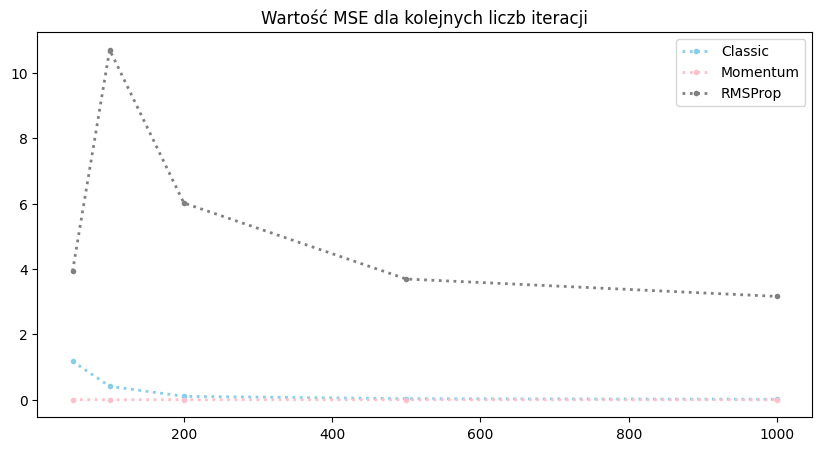

In [12]:
plot_mse(iterations_set, results_classic, results_momentum, results_rmsprop)

MSE: 0.015704881329187705 0.00040465880878734804 3.1639689304542085


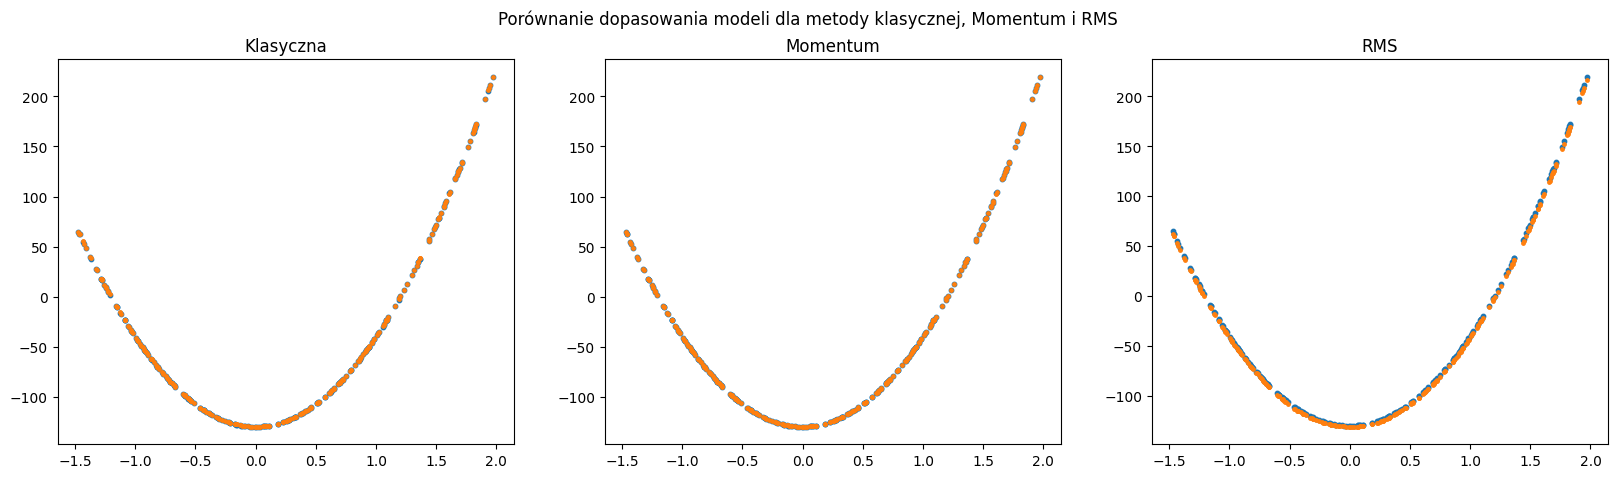

In [13]:
plot_compare_3_pred(x_test, y_test, y_pred_classic, y_pred_momentum, y_pred_rmsprop)

## Drugi zbiór danych (*steps large*)

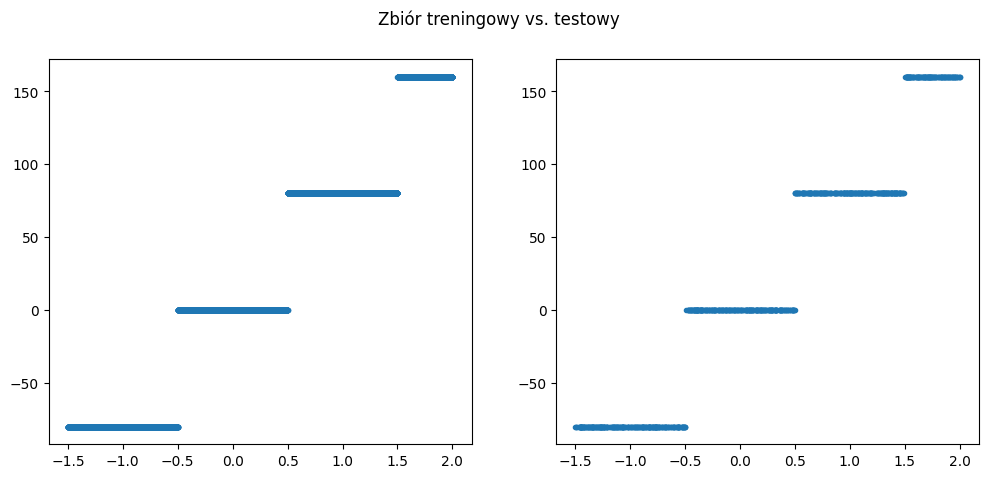

In [14]:
train_df = pd.read_csv('steps-large-training.csv', index_col=0)
test_df = pd.read_csv('steps-large-test.csv', index_col=0)

x = np.asarray(train_df['x']).reshape(-1, 1)
y = np.asarray(train_df['y']).reshape(-1, 1)
x_test = np.asarray(test_df['x']).reshape(-1,1)
y_test = np.asarray(test_df['y']).reshape(-1, 1)

plot_train_test(x,y,x_test,y_test)

In [15]:
# iterations_set = [20, 100, 150, 200]
number_of_neurons=[1, 10, 10, 10, 10, 1]

results_classic = []
results_momentum = []
results_rmsprop = []

min_mse_classic = np.inf
min_mse_momentum = np.inf
min_mse_rmsprop = np.inf

nn_classic_best = None
nn_momentum_best = None
nn_rmsprop_best = None

for iterations in iterations_set:
    nn_classic = NeuralNetwork(number_of_neurons = number_of_neurons, activation = sigmoid, activation_der = sigmoid_der, initiate_w_b = "Uniform")
    nn_classic.learn(x, y, iterations=iterations, batch_size = 20, alpha=0.003, method = "Classic")
    y_pred_classic = nn_classic.forward(x_test)  # predykcja
    results_classic.append(mse(y_test, y_pred_classic))  # dodajemy MSE z predyckji vs real vals
    if min_mse_classic > mse(y_test, y_pred_classic):   # gdy natrafimy na nowy dobry model, podmieniamy
        nn_classic_best = nn_classic
        min_mse_classic = mse(y_test, y_pred_classic)

    nn_momentum = NeuralNetwork(number_of_neurons = number_of_neurons, activation = sigmoid, activation_der = sigmoid_der, initiate_w_b = "Uniform")
    nn_momentum.learn(x, y, iterations=iterations, batch_size = 20, alpha=0.01, var=0.01, method = "Momentum")
    y_pred_momentum = nn_momentum.forward(x_test)
    results_momentum.append(mse(y_test, y_pred_momentum))
    if min_mse_momentum > mse(y_test, y_pred_momentum):
        nn_momentum_best = nn_momentum
        min_mse_momentum = mse(y_test, y_pred_momentum)

    nn_rmsprop = NeuralNetwork(number_of_neurons = number_of_neurons, activation = sigmoid, activation_der = sigmoid_der, initiate_w_b = "Uniform")
    # nn_rmsprop.learn(x, y, iterations=iterations, batch_size = 20, alpha=0.03, var=0.1, method = "RMSProp")
    nn_rmsprop.learn(x, y, iterations=iterations, batch_size = 20, alpha=0.05, var=0.9, method = "RMSProp")
    y_pred_rmsprop = nn_rmsprop.forward(x_test)
    results_rmsprop.append(mse(y_test, y_pred_rmsprop))
    if min_mse_rmsprop > mse(y_test, y_pred_rmsprop):
        nn_rmsprop_best = nn_rmsprop
        min_mse_rmsprop = mse(y_test, y_pred_rmsprop)

y_pred_classic = nn_classic_best.forward(x_test)
y_pred_momentum = nn_momentum_best.forward(x_test)
y_pred_rmsprop = nn_rmsprop_best.forward(x_test)

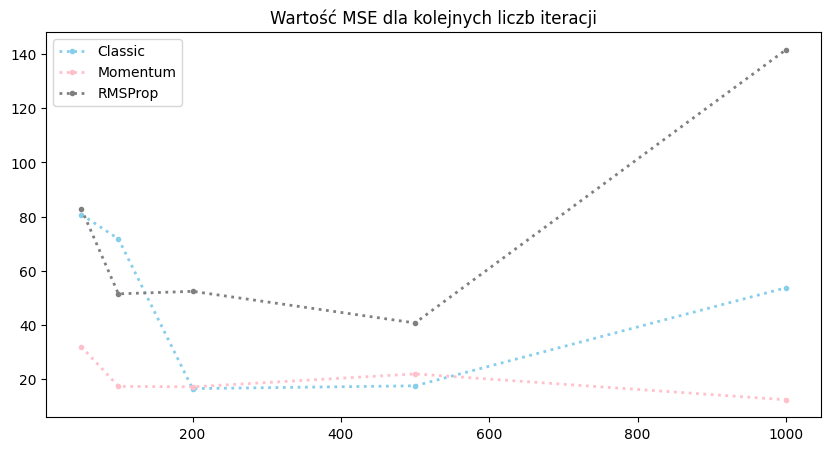

In [16]:
plot_mse(iterations_set, results_classic, results_momentum, results_rmsprop)

MSE: 16.555656875959727 12.438687737925555 40.78791473495584


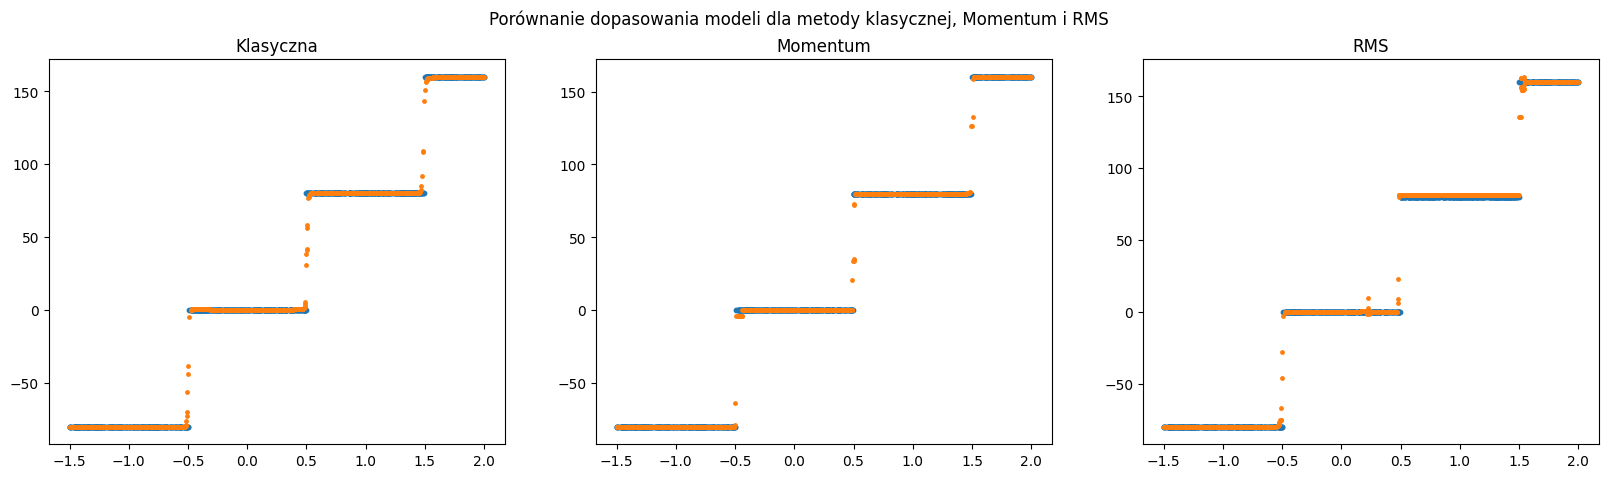

In [17]:
plot_compare_3_pred(x_test, y_test, y_pred_classic, y_pred_momentum, y_pred_rmsprop)

## Trzeci zbiór danych (*multimodal large*)

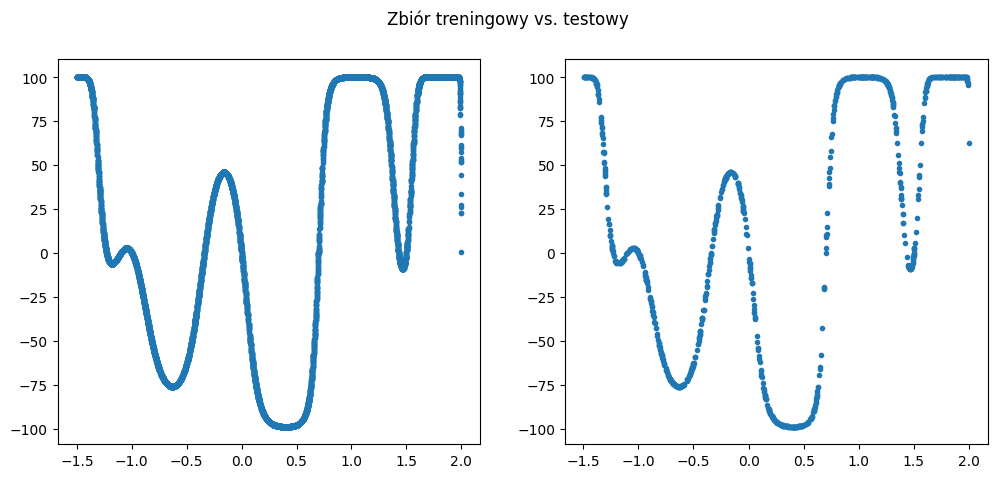

In [19]:
train_df = pd.read_csv('multimodal-large-training.csv')
test_df = pd.read_csv('multimodal-large-test.csv')

x = np.asarray(train_df['x']).reshape(-1, 1)
y = np.asarray(train_df['y']).reshape(-1, 1)
x_test = np.asarray(test_df['x']).reshape(-1,1)
y_test = np.asarray(test_df['y']).reshape(-1, 1)

plot_train_test(x,y,x_test,y_test)

In [20]:
# iterations_set = [20, 100, 150, 200]
number_of_neurons=[1, 50, 50, 50, 1]

results_classic = []
results_momentum = []
results_rmsprop = []

min_mse_classic = np.inf
min_mse_momentum = np.inf
min_mse_rmsprop = np.inf

nn_classic_best = None
nn_momentum_best = None
nn_rmsprop_best = None

for iterations in iterations_set:
    nn_classic = NeuralNetwork(number_of_neurons = number_of_neurons, activation = sigmoid, activation_der = sigmoid_der, initiate_w_b = "Uniform")
    nn_classic.learn(x, y, iterations=iterations, batch_size = 20, alpha=0.001, method = "Classic")
    y_pred_classic = nn_classic.forward(x_test)  # predykcja
    results_classic.append(mse(y_test, y_pred_classic))  # dodajemy MSE z predyckji vs real vals
    if min_mse_classic > mse(y_test, y_pred_classic):   # gdy natrafimy na nowy dobry model, podmieniamy
        nn_classic_best = nn_classic
        min_mse_classic = mse(y_test, y_pred_classic)

    nn_momentum = NeuralNetwork(number_of_neurons = number_of_neurons, activation = sigmoid, activation_der = sigmoid_der, initiate_w_b = "Uniform")
    nn_momentum.learn(x, y, iterations=iterations, batch_size = 20, alpha=0.001, var=0.8, method = "Momentum")
    y_pred_momentum = nn_momentum.forward(x_test)
    results_momentum.append(mse(y_test, y_pred_momentum))
    if min_mse_momentum > mse(y_test, y_pred_momentum):
        nn_momentum_best = nn_momentum
        min_mse_momentum = mse(y_test, y_pred_momentum)

    nn_rmsprop = NeuralNetwork(number_of_neurons = number_of_neurons, activation = sigmoid, activation_der = sigmoid_der, initiate_w_b = "Uniform")
    nn_rmsprop.learn(x, y, iterations=iterations, batch_size = 50, alpha=0.01, var=0.7, method = "RMSProp")
    y_pred_rmsprop = nn_rmsprop.forward(x_test)
    results_rmsprop.append(mse(y_test, y_pred_rmsprop))
    if min_mse_rmsprop > mse(y_test, y_pred_rmsprop):
        nn_rmsprop_best = nn_rmsprop
        min_mse_rmsprop = mse(y_test, y_pred_rmsprop)

y_pred_classic = nn_classic_best.forward(x_test)
y_pred_momentum = nn_momentum_best.forward(x_test)
y_pred_rmsprop = nn_rmsprop_best.forward(x_test)

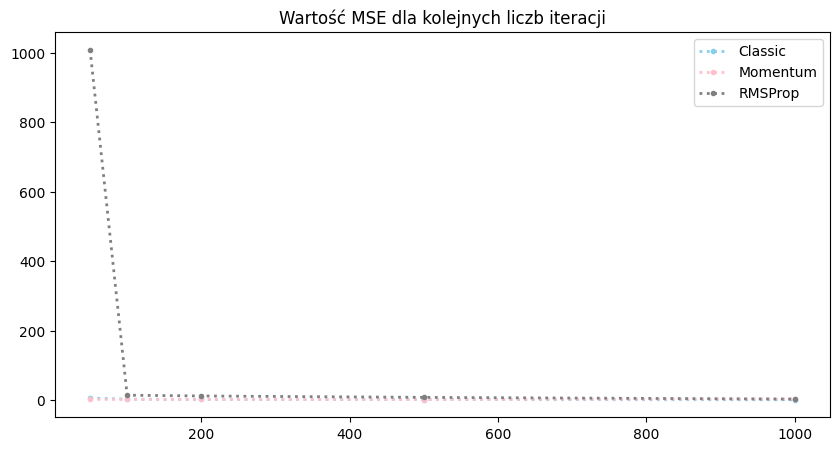

In [21]:
plot_mse(iterations_set, results_classic, results_momentum, results_rmsprop)

MSE: 0.6566749932578173 1.1943205927907958 2.5925744716553885


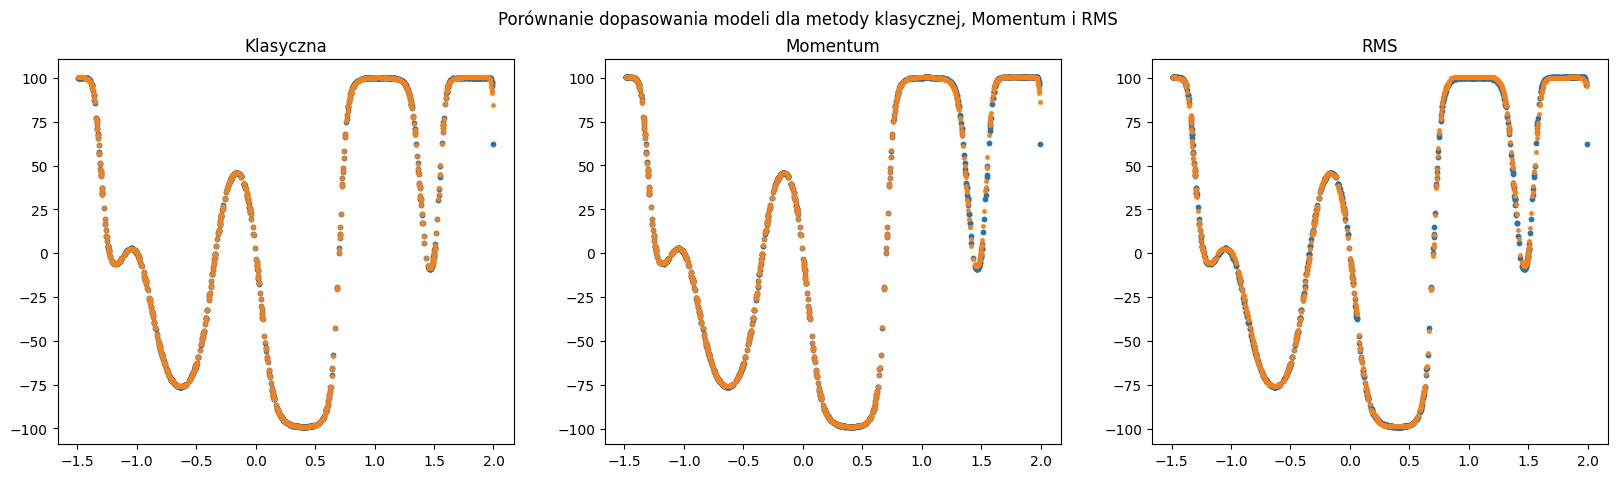

In [22]:
plot_compare_3_pred(x_test, y_test, y_pred_classic, y_pred_momentum, y_pred_rmsprop)

## Podsumowanie

**MSE** dla kolejnych metod:
| Zbiór danych | Klasyczna | Momentum | RMS |
|--------------|--------|--------|---------|
| square-large* | 0.015 (47.058) | 0 (45.997) | 3.163 (87.246) |
| steps-large | 16.555 | 12.438 | 40.787 |
| multimodal-large | 0.656 | 1.194 | 2.592 |

W badanych przypadkach najlepsze wyniki daje metoda klasyczna lub z zastosowaniem momentum. Być może RMS można dopracować przy odpowiednim doborze parametrów. Oprócz tego, nie udało się odpowiednio dobrać modelu aby ulepszyć MSE dla zbioru `steps-large`, co było problemem również przy NN2.

Jednak, poza tym modele dopasowują sie dosyć sensownie, co pokazują wyniki i wizualizacje.

*wyniki w nawiasach odnoszą się do oryginalnych danych testowych (nieuciętych)